## Text Processing Lab

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [ ]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Calculate the Levenshtein distance between two strings.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    int
        The Levenshtein distance between s1 and s2.

    Example
    -------
    >>> levenshtein_distance("kitten", "sitting")
    3
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row: list[int] = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row: list[int] = [i + 1]
        for j, c2 in enumerate(s2):
            insertions: int = previous_row[j + 1] + 1
            deletions: int = current_row[j] + 1
            substitutions: int = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def compute_string_similarity(s1: str, s2: str) -> float:
    """
    Compute the similarity between two strings based on Levenshtein distance.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    float
        A similarity score between 0 and 1, where 1 indicates identical strings.
    """
    distance: int = levenshtein_distance(s1, s2)
    max_length: int = max(len(s1), len(s2))
    similarity: float = 1 - (distance / max_length)
    return round(similarity, 4)

In [ ]:
s1, s2 = "friend", "fiend"
distance: int = levenshtein_distance(s1=s1, s2=s2)
print(distance)

similarity: float = compute_string_similarity(s1=s1, s2=s2)
print(similarity)

1
0.8333


In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result

In [4]:
# fp: str = "./sample.txt"
fp: str = "../../data/categories.txt"

with open(fp, "r", encoding="latin-1") as f:
    texts: list[str] = f.readlines()

In [5]:
result: list[str] = process_text(text=texts)

Processing Text: 100%|█████████████████████████████| 7313587/7313587 [00:06<00:00, 1156851.62line/s]


### Exploratory Data Analysis (EDA)

In [6]:
data: pl.DataFrame = (
    pl.DataFrame(result)
    .select(
        pl.col("column_0")
        .str.split_exact(":", 1)
        .struct.rename_fields(["product_id", "product_category"])
    )
    .unnest("column_0")
).with_columns(product_category=pl.col("product_category").str.strip())

# Drop duplicates
data = data.unique(subset=["product_id", "product_category"])
print(f"{data.shape = }")
data.head(10)

data.shape = (4869346, 2)


product_id,product_category
str,str
"""B0000002WR""","""Music, R&B"""
"""0745186378""","""Books, Literature & Fiction, United States"""
"""039527818X""","""Books, Education & Reference, Words, Language & Grammar, Reading Skills"""
"""B00000EWJE""","""Music, Pop"""
"""0879518170""","""Books, History, Asia, Nepal"""
"""B000E1FT8I""","""Patio, Lawn & Garden, Patio Furniture & Accessories, Decorative Pillows"""
"""0892812125""","""Books, Religion & Spirituality, New Age, Reference"""
"""B0007FDR0I""","""Books"""
"""B0006TQU36""","""Pet Supplies, Cats, Feeding & Watering Supplies, Automatic Feeders"""


In [7]:
# Clean up the data
data = data.with_columns(
    product_category=pl.col("product_category").map_elements(
        lambda x: ", ".join(set(x.split(","))).strip()
    )
)

data.head(10)

product_id,product_category
str,str
"""B0000002WR""","""R&B, Music"""
"""0745186378""","""United States, Books, Literature & Fiction"""
"""039527818X""","""Books, Language & Grammar, Education & Reference, Reading Skills, Words"""
"""B00000EWJE""","""Pop, Music"""
"""0879518170""","""Nepal, Asia, Books, History"""
"""B000E1FT8I""","""Patio, Decorative Pillows, Lawn & Garden, Patio Furniture & Accessories"""
"""0892812125""","""Reference, New Age, Books, Religion & Spirituality"""
"""B0007FDR0I""","""Books"""
"""B0006TQU36""","""Automatic Feeders, Cats, Feeding & Watering Supplies, Pet Supplies"""


In [8]:
# data_grpby: pl.DataFrame = data.group_by("product_id").agg(
#     pl.col("product_category").explode()
# )

# OR
data_grpby: pl.DataFrame = data.groupby("product_id").agg(
    pl.col("product_category").map_elements(lambda x: " ".join(x))
)

# OR
# data_grpby: pl.DataFrame = data.group_by("product_id").agg((pl.struct(pl.col("product_category"))))
data_grpby.head()

product_id,product_category
str,str
"""0793820685""","""Crafts, Pets & Animal Care, Books, Reptiles & Amphibians, Hobbies & Home Science & Math, Books, Reptiles & Amphibians, Animals, Biological Sciences"""
"""B00000K23F""","""Music"""
"""0791449521""","""Books, Politics & Social Sciences, Discrimination & Racism, Sociology, Race Relations Books, Specific Demographics, Politics & Social Sciences, Social Sciences, Ethnic Studies Mortgages, Business & Investing, Real Estate, Books Business & Investing, Money & Monetary Policy, Books, Economics"""
"""B00004LMD0""","""Latin Music, Music World Music, Music"""
"""B00004YZTC""","""Pop, Music Soundtracks, Music R&B, Music"""


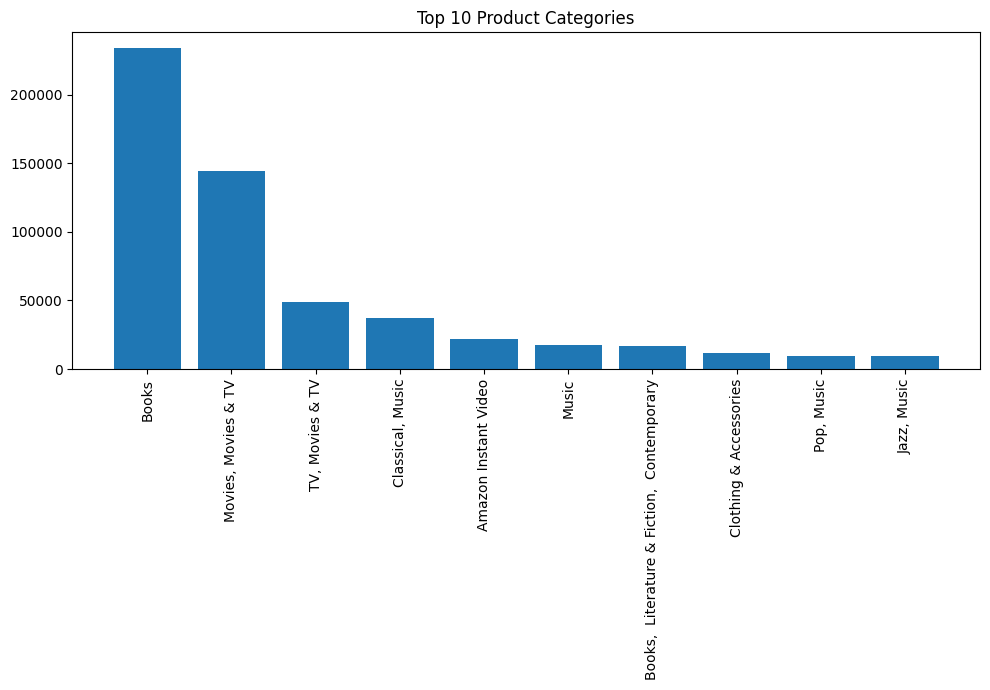

In [9]:
N: int = 10
d: pl.DataFrame = (
    data_grpby.select("product_category").to_series().value_counts(sort=True).head(N)
)
plt.figure(figsize=(10, 7))
plt.bar(d["product_category"], d["count"])
plt.xticks(rotation=90)
plt.title(f"Top {N} Product Categories")
plt.tight_layout()
plt.show()

In [10]:
data_grpby.filter(pl.col("product_id").eq("B000068VAX"))

product_id,product_category
str,str
"""B000068VAX""","""Children's, Software, Art & Creativity Children's, Software, Early Learning"""


In [11]:
import polars as pl
from typing import Generator


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [12]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [13]:
fp: str = "../../data/Software.txt"
df_reviews: pl.DataFrame = read_reviews(fp).with_columns(
    pl.col("review/score").cast(pl.Float32).alias("review/score")
)
print(f"{df_reviews.shape = }")
df_reviews.head(2)

df_reviews.shape = (95085, 10)


product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
str,str,str,str,str,str,f32,str,str,str
"""B000068VBQ""","""Fisher-Price Rescue Heroes: Lava Landslide""","""8.88""","""unknown""","""unknown""","""11/11""",2.0,"""1042070400""","""Requires too much coordination""","""I bought this software for my 5 year old. He has a couple of the other RH software games and he lik…"
"""B000068VBQ""","""Fisher-Price Rescue Heroes: Lava Landslide""","""8.88""","""unknown""","""unknown""","""9/10""",2.0,"""1041552000""","""You can't pick which parts you want to play!""","""I got this for my 4 year old son because he really likes Rescue Heroes and it sounded like it would…"


In [14]:
# Join the tables
merged_data: pl.DataFrame = df_reviews.join(
    data_grpby, left_on="product/productId", right_on="product_id", how="left"
)
merged_data = merged_data.unique(subset=["product/productId", "review/userId"])
print(f"{merged_data.shape = }")
merged_data.head(10)

merged_data.shape = (84992, 11)


product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B0002LXRXY""","""ACT! 2005 [Old Version]""","""69.95""","""A1Y1DGWO5VHFFA""","""Fred24""","""14/16""",3.0,"""1093910400""","""Needs Work""","""That first review above has got to be from Best Software. This release is far from excellent. Openi…","""Contact Management, Software, Business & Office"""
"""B000EMA356""","""The Word Bible Collection Suite""","""unknown""","""A1RT9Q6TQGDARE""","""Michael Silverman ""Mike""""","""1/1""",1.0,"""1170028800""","""Not as advertised""","""Although the software is pretty good. It came with neither the Christian Greeting Card software of …","""Home & Hobbies, Software Software, Religion, Education & Reference"""
"""B00081G316""","""Adobe GoLive CS2 [Old Version]""","""unknown""","""A3QI2UWSL6K00R""","""James Welch""","""6/8""",1.0,"""1149552000""","""Don't Waste Your Money on This Software""","""Adobe GoLive CS2 is easily the worst application I've used in years. I went through the Adobe GoLiv…","""Software, Programming & Web Development, Web Development, Professional Development Software, Il…"
"""B0006LCHX6""","""Panda Titanium AntiVirus 2005""","""unknown""","""AXH9OLF9PGM7H""","""holodoctor1""","""10/11""",2.0,"""1103846400""","""Slowed computer and BAD customer support""","""I bought this Panda product after it was recommended by a computer supply store. I had always had M…","""Networking, Software, Security Computer Security, Software Software, Utilities"""
"""B000BSEWFA""","""Garmin City Navigator for Detailed Maps of Brazil (microSD/SD Card)""","""45.00""","""AQ963H2HGN0MC""","""Dr. E. De FLOR ""traveler on a string""""","""14/14""",3.0,"""1181174400""","""Garmin City Navigator NT 9 SD Data Card for Garmin Units, Spain and Portugal (010-10698-00) (Purcha…","""This review refers to NT version 9 which I have used for 4 weeks in May/june 2007 to drive both in …","""Language & Travel, Software"""
"""B00002S5UF""","""InoculateIT Workgroup Advanced Edition 4.53 (1-user Client Agent)""","""unknown""","""unknown""","""unknown""","""0/0""",5.0,"""1001980800""","""best antivirus""","""I have had other antivirus programs like mcafee and nortons but non of them are as good as this pro…","""Computer Security, Internet Security, Software Computer Security, Antivirus, Software"""
"""B000GEQ0HW""","""Nikon Capture NX Software for Windows and Mac""","""unknown""","""A366QJUHRJP3IU""","""Richard Martin ""Kofy""""","""3/4""",5.0,"""1183593600""","""Capture NX in realtime""","""After recently purchasing Capture NX I have found that it opens up a whole new set of tools for enh…","""Camera & Photo, Electronics, Digital Camera Accessories, Accessories Photo Editing, Software"""
"""B00005JL8K""","""3d Space Station Adventure (2001)""","""unknown""","""A3SJYAL87JZECT""","""Darke Retribution""","""22/32""",1.0,"""1289952000""","""Begins Making You Confused...Gets Boring Fast...""","""Well this is going to be an honest review of this movie. This is actually the first negative review…","""Movies, Movies & TV Children's, Software"""
"""B0003009IK""","""ScanSoft Dragon NaturallySpeaking 8 Preferred [Old Version]""","""33.88""","""A1OSSMGR0EY3S1""","""Putney Mountain""","""26/42""",1.0,"""1105747200""","""Worst possible software.""","""What makes it so bad? It takes a bunch of your time before you realize its a ""no go."" So you are ou…","""Software, Utilities"""


posx and posy should be finite values
posx and posy should be finite values


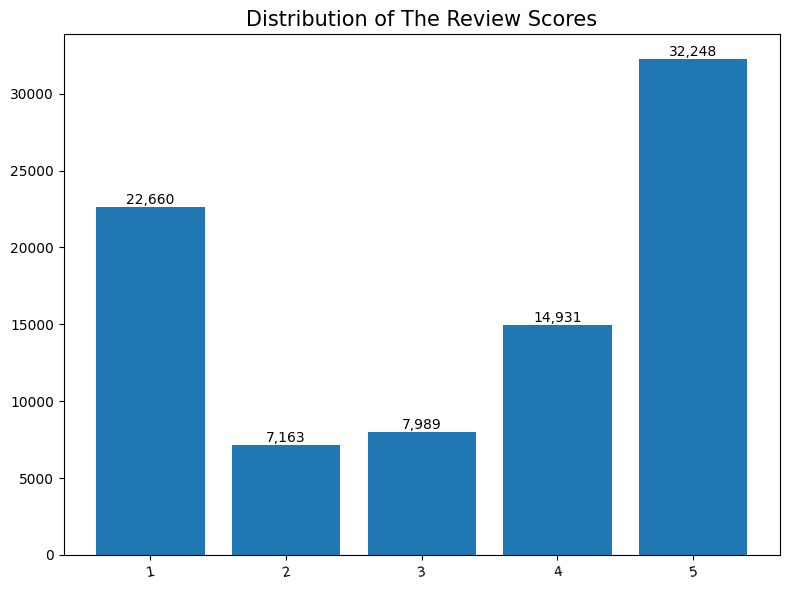

In [15]:
x_val: str = "review/score"
d: pl.DataFrame = merged_data.select(x_val).to_series().value_counts(sort=True)

plt.figure(figsize=(8, 6))
bars = plt.bar(d[x_val], d["count"])
plt.xticks(rotation=10)
plt.title(f"Distribution of The Review Scores", fontsize=15)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )
plt.tight_layout()
plt.show()

In [16]:
x_val: str = "product/title"
d = merged_data.select(x_val).to_series().value_counts(sort=True).head(10)
# Reduce the length of the product names
d.with_columns(pl.col(x_val).str.slice(offset=0, length=20).alias(x_val))

product/title,count
str,u32
"""Microsoft Office Hom""",2143
"""Garmin City Navigato""",792
"""Apple Mac OS X Versi""",460
"""TurboTax Deluxe 2002""",357
"""Roxio Easy Media Cre""",322
"""Microsoft Windows XP""",304
"""National Geographic """,300
"""2006 TurboTax Deluxe""",292
"""Microsoft Office Pro""",288


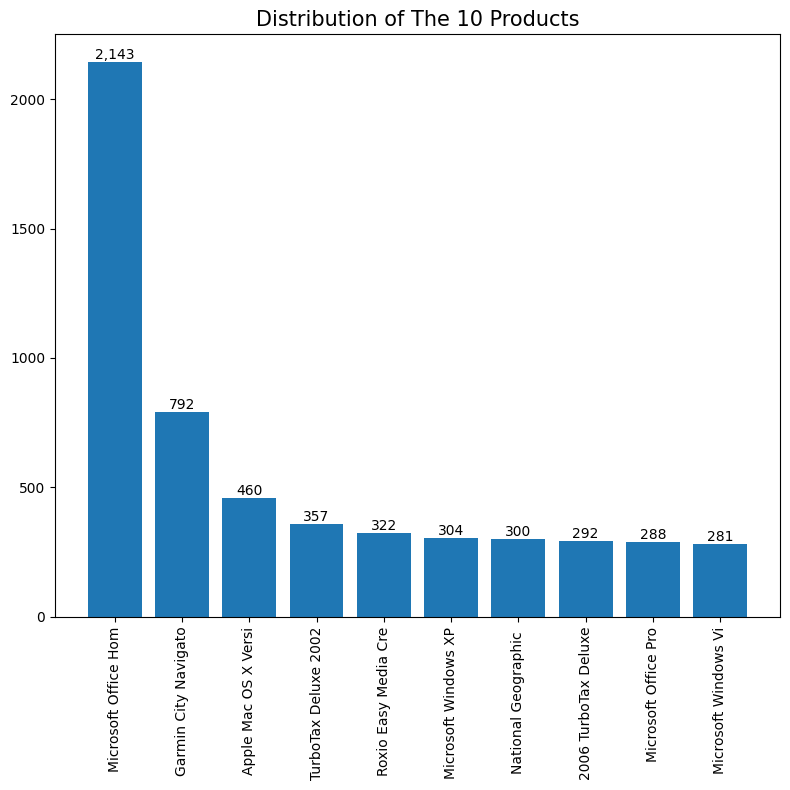

In [17]:
N: int = 10
x_val: str = "product/title"
d: pl.DataFrame = merged_data.select(x_val).to_series().value_counts(sort=True).head(N)
# Reduce the length of the product names
d = d.with_columns(pl.col(x_val).str.slice(offset=0, length=20).alias(x_val))

plt.figure(figsize=(8, 8))
bars = plt.bar(d[x_val], d["count"])
plt.xticks(rotation=90)
plt.title(f"Distribution of The {N} Products", fontsize=15)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [18]:
# Check the length of the reviews
merged_data = merged_data.with_columns(
    review_length=pl.col("review/text").str.len_chars()
)
merged_data = merged_data.drop_nulls()
merged_data.describe((0.25, 0.5, 0.75, 0.99))

statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length
str,str,str,str,str,str,str,f64,str,str,str,str,f64
"""count""","""84991""","""84991""","""84991""","""84991""","""84991""","""84991""",84991.0,"""84991""","""84991""","""84991""","""84991""",84991.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,3.317022,null,null,null,null,718.969714
"""std""",null,null,null,null,null,null,1.656402,null,null,null,null,824.959797
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""","""0/0""",1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Software, Illustration & Design Brain Teasers, Puzzles, Toys …",11.0
"""25%""",null,null,null,null,null,null,1.0,null,null,null,null,255.0
"""50%""",null,null,null,null,null,null,4.0,null,null,null,null,485.0
"""75%""",null,null,null,null,null,null,5.0,null,null,null,null,875.0
"""99%""",null,null,null,null,null,null,5.0,null,null,null,null,3888.0


In [19]:
# Drop outlier values
threshold: float = np.percentile(
    merged_data["review_length"].to_numpy().reshape(-1, 1), q=99.0
).round(2)
print(f"{threshold = }")
merged_data = merged_data.filter(pl.col("review_length").lt(threshold))
merged_data.describe((0.25, 0.5, 0.75, 0.99))

threshold = 3888.4


statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length
str,str,str,str,str,str,str,f64,str,str,str,str,f64
"""count""","""84141""","""84141""","""84141""","""84141""","""84141""","""84141""",84141.0,"""84141""","""84141""","""84141""","""84141""",84141.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,3.313985,null,null,null,null,669.928964
"""std""",null,null,null,null,null,null,1.658473,null,null,null,null,614.166979
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""","""0/0""",1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Software, Illustration & Design Brain Teasers, Puzzles, Toys …",11.0
"""25%""",null,null,null,null,null,null,1.0,null,null,null,null,253.0
"""50%""",null,null,null,null,null,null,4.0,null,null,null,null,480.0
"""75%""",null,null,null,null,null,null,5.0,null,null,null,null,857.0
"""99%""",null,null,null,null,null,null,5.0,null,null,null,null,3080.0


In [20]:
# Do longer reviews represent a positive or negative sentiment?
merged_data.group_by("review/score").agg(pl.col("review_length").mean()).sort(
    "review_length", descending=True
)

review/score,review_length
f32,f64
2.0,806.487784
3.0,758.374841
4.0,717.186871
1.0,676.937237
5.0,591.15565


In [21]:
merged_data.sample(5, seed=1).select(["review/helpfulness", "review/score"])

review/helpfulness,review/score
str,f32
"""1/3""",1.0
"""13/13""",1.0
"""16/17""",1.0
"""4/4""",5.0
"""23/26""",5.0


In [22]:
merged_data = merged_data.with_columns(
    pl.col("review/helpfulness")
    .map_elements(
        lambda x: int(x.split("/")[0])
        / (1 if int(x.split("/")[1]) == 0 else int(x.split("/")[1]))
    )
    .alias("review/helpfulness"),
    sentiment=pl.when(pl.col("review/score").le(3.0))
    .then(pl.lit(0))  # -ve
    .otherwise(pl.lit(1)),  # +ve
)

merged_data.describe()

statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length,sentiment
str,str,str,str,str,str,f64,f64,str,str,str,str,f64,f64
"""count""","""84141""","""84141""","""84141""","""84141""","""84141""",84141.0,84141.0,"""84141""","""84141""","""84141""","""84141""",84141.0,84141.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,null,null,null,null,0.620376,3.313985,null,null,null,null,669.928964,0.554462
"""std""",null,null,null,null,null,0.408315,1.658473,null,null,null,null,614.166979,0.497028
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""",0.0,1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Software, Illustration & Design Brain Teasers, Puzzles, Toys …",11.0,0.0
"""25%""",null,null,null,null,null,0.071429,1.0,null,null,null,null,253.0,0.0
"""50%""",null,null,null,null,null,0.8,4.0,null,null,null,null,480.0,1.0
"""75%""",null,null,null,null,null,1.0,5.0,null,null,null,null,857.0,1.0
"""max""","""B0076ZOW3I""","""yGuide Yoga Software with Ashtanga Yoga & Great Poses I""","""unknown""","""unknown""","""~Vera""",1.0,5.0,"""999993600""","""~~~WARNING! USE THIS PRODUCT AT YOUR OWN RISK! ~~~""","""~~~The tech support was useless. I called four times without my problems being solved. All four rep…","""e-Commerce, Software, Programming & Web Development, Web Development Software, Internet Utilitie…",3888.0,1.0


In [23]:
merged_data["sentiment"].value_counts()

sentiment,count
i32,u32
0,37488
1,46653


## Build Classifiers

In [24]:
positive_size: int = (
    merged_data["sentiment"]
    .to_numpy()[merged_data["sentiment"].to_numpy() == 1]
    .shape[0]
)
total_size: int = merged_data["sentiment"].to_numpy().shape[0]
base_line_acc: float = (positive_size / total_size) * 100
print(f"Base line accuracy: {base_line_acc: .2f}%")

Base line accuracy:  55.45%


In [25]:
from spacy.lang.en.stop_words import STOP_WORDS


stopwords: list[str] = list(STOP_WORDS)


def tokenizer(text: str) -> list[str]:
    return text.split()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


test_size: float = 0.2
seed: int = 123

X: np.ndarray = merged_data["review/text"].to_numpy()
y: np.ndarray = merged_data["sentiment"].to_numpy()

print(f"{X.shape = } | {y.shape = }")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=test_size, random_state=seed
)
print(f"{X_train.shape = } | {X_test.shape = }")

X.shape = (84141,) | y.shape = (84141,)
X_train.shape = (67312,) | X_test.shape = (16829,)


In [27]:
from scipy.sparse import csr_matrix


max_features: int = 40_000
tfidf_vect: TfidfVectorizer = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
)
X_train_tfidf: csr_matrix = tfidf_vect.fit_transform(X_train)
X_test_tfidf: csr_matrix = tfidf_vect.transform(X_test)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from utils.ml import (
    train_model_with_cross_validation,
    plot_confusion_matrix,
    calculate_precision_recall_curves,
    plot_precision_recall_curves,
    calculate_roc_curve,
    plot_roc_curves,
)


n_components: int = 1_000
lr_pipe: Pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
            ),
        ),
        # ("lsa", TruncatedSVD(n_components=n_components, random_state=seed)),
        (
            "lr",
            LogisticRegression(penalty="l2", C=1, max_iter=5_000, random_state=seed),
        ),
    ]
)
lr_pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=40000,
                                 stop_words=['to', 'least', 'on', 'themselves',
                                             'via', 'please', 'whereby',
                                             'never', 'and', 'her', 'became',
                                             'back', 'each', 'except',
                                             'whenever', 'because', 'one',
                                             'six', 'though', "'m", 'yet', '‘m',
                                             'none', 'two', 'last', 'yours',
                                             'are', 'yourselves', 'when', 'any', ...],
                                 tokenizer=<function tokenizer at 0x1761723e0>)),
                ('lr',
                 LogisticRegression(C=1, max_iter=5000, random_state=123))])

In [29]:
lr_pipe: Pipeline
lr_pipe, acc_scores, _, _ = train_model_with_cross_validation(
    X=X_train, y=y_train, estimator=lr_pipe, n_splits=5
)

Fold:  1 | Class dist.: [23992 29857] | Acc: 0.852
Fold:  2 | Class dist.: [23992 29857] | Acc: 0.846
Fold:  3 | Class dist.: [23992 29858] | Acc: 0.851
Fold:  4 | Class dist.: [23992 29858] | Acc: 0.849
Fold:  5 | Class dist.: [23992 29858] | Acc: 0.847

CV accuracy: 0.849 +/- 0.002

Time taken: 22.220 seconds


In [30]:
n_features: int = lr_pipe.named_steps["tfidf"].vocabulary_.__len__()
# n_features: int = lr_pipe.named_steps["lsa"].n_components
print(f"Number of features: {n_features:,}")

Number of features: 40,000


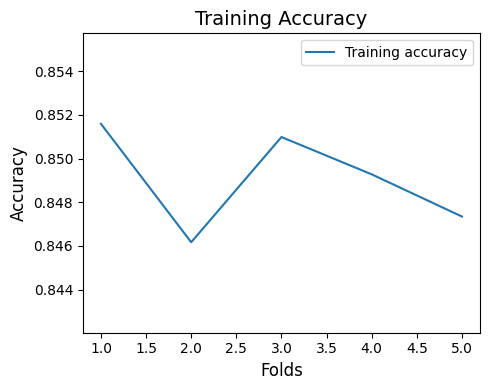

In [31]:
plt.figure(figsize=(5, 4))
min_, max_ = (
    np.min(acc_scores) - (2 * np.std(acc_scores)),
    np.max(acc_scores) + (2 * np.std(acc_scores)),
)
plt.plot(np.arange(1, len(acc_scores) + 1), acc_scores, label="Training accuracy")
plt.ylim(min_, max_)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training Accuracy", fontsize=14)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

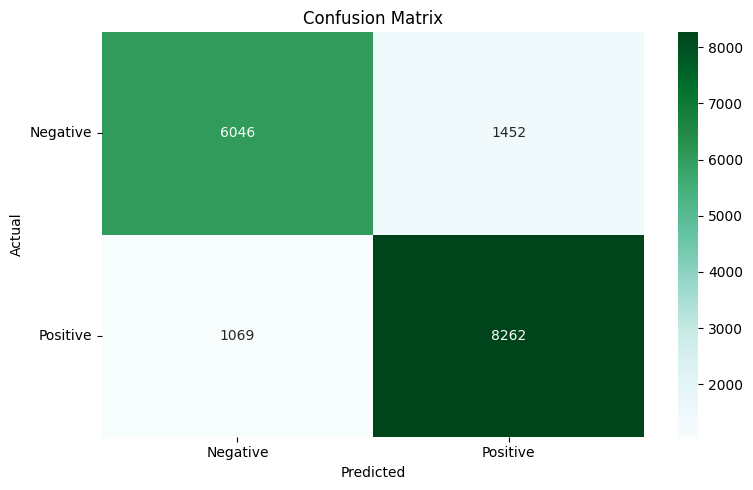

In [32]:
y_pred_train = lr_pipe.predict(X_train)
y_pred_test = lr_pipe.predict(X_test)

plot_confusion_matrix(
    y_true=y_test, y_pred=y_pred_test, labels=["Negative", "Positive"], cmap="BuGn"
)

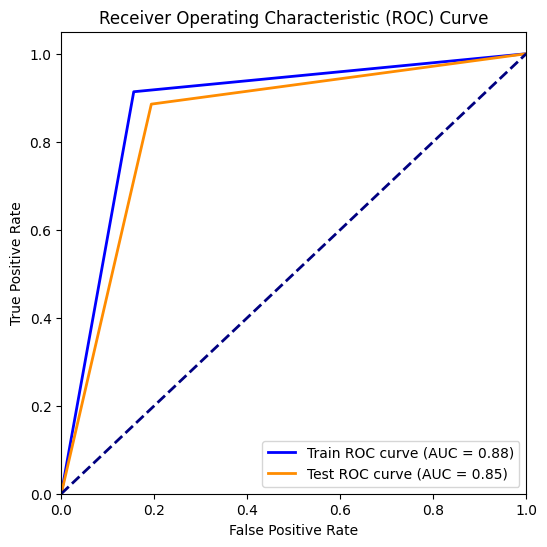

In [33]:
fpr_train, tpr_train, roc_auc_train = calculate_roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, roc_auc_test = calculate_roc_curve(y_test, y_pred_test)

plot_roc_curves(fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test)

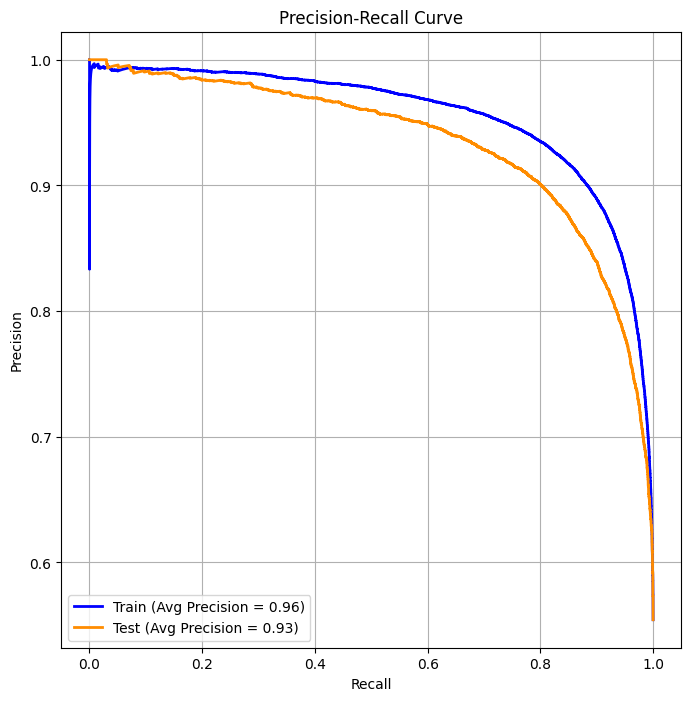

In [34]:
y_proba_train: np.ndarray = lr_pipe.predict_proba(X_train)[:, 1]
y_proba_test: np.ndarray = lr_pipe.predict_proba(X_test)[:, 1]

precision_train, recall_train, precision_test, recall_test, ap_train, ap_test = (
    calculate_precision_recall_curves(y_train, y_test, y_proba_train, y_proba_test)
)

plot_precision_recall_curves(
    recall_train, precision_train, recall_test, precision_test, ap_train, ap_test
)

In [35]:
text: str = "This product is not good. I do not recommend it."
res: list[str] = sorted(["product", "not", "good", "do", "not", "recommend"])
print(f"Actual text: \n{text}")
print(f"\nBoW input: \n{' '.join(res)!r}")
result: str = "Positive" if lr_pipe.predict([text])[0] == 1 else "Negative"
result

Actual text: 
This product is not good. I do not recommend it.

BoW input: 
'do good not not product recommend'


'Positive'

In [36]:
text: str = "This product is awful."
lr_pipe.predict_proba([text])[0]
result: str = "Positive" if lr_pipe.predict([text])[0] == 1 else "Negative"
result

'Negative'

### Neural Networks (For Classification)

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor


class ReviewsDataset(Dataset):
    """
    A dataset class for reviews and their corresponding targets.

    Parameters
    ----------
    reviews : np.ndarray
        Array of reviews. Shape: (n_samples,)
    targets : np.ndarray
        Array of targets. Shape: (n_samples,)

    Attributes
    ----------
    reviews : np.ndarray
        Array of reviews. Shape: (n_samples,)
    targets : np.ndarray
        Array of targets. Shape: (n_samples,)
    """

    def __init__(self, reviews: np.ndarray, targets: np.ndarray) -> None:
        self.reviews: Tensor = torch.tensor(reviews, dtype=torch.float32)
        self.targets: Tensor = torch.tensor(targets, dtype=torch.long)

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.
        """
        return len(self.reviews)

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        """
        Retrieves a single sample from the dataset.
        """
        review: np.ndarray = self.reviews[index]
        target: np.ndarray = self.targets[index]
        return review, target

In [40]:
from sklearn.decomposition import TruncatedSVD


# Test the ReviewsDataset class.
n_components: int = 2_000
sample_df: pl.DataFrame = merged_data.sample(100, shuffle=True)
tfidf_vectorizer: TfidfVectorizer = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
)
lsa_vectorizer: TruncatedSVD = TruncatedSVD(n_components=n_components)

X_vec: csr_matrix = tfidf_vectorizer.fit_transform(
    sample_df["review/text"].to_numpy()
).toarray()
X_sample = lsa_vectorizer.fit_transform(X_vec)
y_sample: np.ndarray = sample_df["sentiment"].to_numpy()
sample_data: ReviewsDataset = ReviewsDataset(X_sample, y_sample)

console.print(sample_data[10:12])

(
    tensor([[ 0.1137, -0.0052, -0.0665,  0.0188,  0.0064, -0.1084, -0.0790,  0.0640,
         -0.0135,  0.0279,  0.0135,  0.3086, -0.0026, -0.0729,  0.0531, -0.1193,
          0.1331, -0.2461, -0.0277,  0.1528,  0.0482,  0.0235,  0.0241, -0.0390,
         -0.0352, -0.0408,  0.0719,  0.1153,  0.3149,  0.1191,  0.0004,  0.1281,
         -0.0905,  0.0818,  0.0802,  0.0379,  0.0938,  0.1293, -0.0056,  0.0132,
          0.1223,  0.1018,  0.0469, -0.0127,  0.0653, -0.2083,  0.1924,  0.0594,
          0.2240, -0.0544,  0.1726, -0.0740, -0.1236, -0.1494, -0.0030, -0.0340,
          0.0366, -0.0427,  0.0423,  0.0117, -0.0740, -0.0383,  0.0787,  0.1037,
         -0.1247,  0.0852,  0.0106, -0.0796, -0.0807,  0.0884, -0.1283,  0.0090,
         -0.1851,  0.2563,  0.0630, -0.0017,  0.1200,  0.0821, -0.0038, -0.0838,
         -0.0891,  0.1151, -0.0242,  0.0498, -0.0248, -0.0448, -0.0923,  0.0985,
         -0.0924,  0.0156, -0.0237, -0.0643,  0.0370, -0.0325,  0.0037,  0.0759,
         -0.0433,  0.0317,  0.0216,  0.0057],
        [ 0.1011, -0.0095, -0.0220, -0.0893,  0.0444,  0.0144,  0.1465, -0.0014,
         -0.1703, -0.0993,  0.2571,  0.1148,  0.0254, -0.0032,  0.0567, -0.0211,
         -0.0989,  0.0939, -0.1174, -0.0181,  0.1412, -0.0207, -0.0863,  0.0367,
         -0.0444,  0.1059,  0.0139,  0.0525, -0.1480, -0.0576, -0.0545,  0.0340,
         -0.0877,  0.0756, -0.0747,  0.0406,  0.2843, -0.1226, -0.1352,  0.1283,
         -0.0106, -0.0922,  0.0705, -0.0389, -0.2096,  0.0576,  0.0212,  0.2405,
          0.0453,  0.0515, -0.1123,  0.0665,  0.0361, -0.0037,  0.3328,  0.1191,
         -0.0961,  0.0692,  0.0454,  0.3283,  0.0227, -0.0457, -0.0599, -0.0248,
         -0.0259,  0.2576,  0.1177, -0.0425, -0.0199, -0.0307,  0.0199,  0.0468,
         -0.1440,  0.0566,  0.0053,  0.0614,  0.1355, -0.0569, -0.0192,  0.0143,
          0.0352, -0.0907,  0.0956,  0.0004,  0.0478,  0.0695, -0.0549,  0.0035,
          0.0338, -0.0117,  0.0304,  0.0235, -0.0552,  0.0127,  0.0327,  0.0505,
          0.0161,  0.0433,  0.0086, -0.0118]]),
    tensor([1, 1])
)

In [41]:
test_size: float = 0.1

vect_pipe: Pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
            ),
        ),
        ("lsa", TruncatedSVD(n_components=n_components)),
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=test_size, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=test_size, random_state=seed
)

X_train_vec: np.ndarray = vect_pipe.fit_transform(X_train)
X_test_vec: np.ndarray = vect_pipe.transform(X_test)
X_val_vec: np.ndarray = vect_pipe.transform(X_val)

print(f"{X_train.shape = } | {X_test.shape = } | {X_val.shape = } ")

X_train.shape = (68153,) | X_test.shape = (8415,) | X_val.shape = (7573,) 


In [42]:
batch_size: int = 64

train_dataset: ReviewsDataset = ReviewsDataset(reviews=X_train_vec, targets=y_train)
test_dataset: ReviewsDataset = ReviewsDataset(reviews=X_test_vec, targets=y_test)
val_dataset: ReviewsDataset = ReviewsDataset(reviews=X_val_vec, targets=y_val)

train_dataloader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dataloader: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)
val_dataloader: DataLoader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [43]:
from typing import TypedDict


class ModelArgs(TypedDict):
    num_features: int
    hidden_size: int
    dropout_rate: float
    num_classes: int


model_args: ModelArgs = {
    "num_features": n_components,
    "hidden_size": 2**6,
    "dropout_rate": 0.2,
    "num_classes": 2,
}
model_args

{'num_features': 2000,
 'hidden_size': 64,
 'dropout_rate': 0.2,
 'num_classes': 2}

In [44]:
model_args["num_classes"]

2

In [45]:
from torch import Tensor, nn


class ReviewsClassifier(nn.Module):
    def __init__(self, model_args: ModelArgs) -> None:
        super().__init__()

        self.dropout = nn.Dropout(model_args["dropout_rate"])
        self.out_layer = nn.Sequential(
            nn.Linear(model_args["num_features"], model_args["hidden_size"]),
            nn.Linear(model_args["hidden_size"], model_args["hidden_size"]),
            nn.Linear(model_args["hidden_size"], model_args["num_classes"]),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.out_layer(x)
        x = self.softmax(x)
        return x

In [46]:
# Test the model
dummy_model: ReviewsClassifier = ReviewsClassifier(model_args)
dummy_model(torch.tensor(X_test_vec[:30], dtype=torch.float32)).shape

torch.Size([30, 2])

In [47]:
from utils.neural_net_utils import (
    train_classifier_mlp,
    plot_values,
)
from sklearn import metrics

In [48]:
mlp_classifier: ReviewsClassifier = ReviewsClassifier(model_args)

# Disable dropout
mlp_classifier.eval()

y_pred_val: Tensor = mlp_classifier(torch.tensor(X_val_vec, dtype=torch.float32))
acc: float = metrics.accuracy_score(y_val, y_pred_val.argmax(dim=1))

print(f"Validation accuracy [Random Model Weights]: {acc:.3f}")

Validation accuracy [Random Model Weights]: 0.554


In [49]:
from torch.optim import Adam

learning_rate: float = 1e-4
num_epochs: int = 10
eval_freq: int = 100
eval_iter: int = 50
optimizer = Adam(mlp_classifier.parameters(), lr=learning_rate)
device: torch.device | str = "cuda" if torch.cuda.is_available() else "cpu"

model, train_losses, val_losses, train_accs, val_accs, examples_seen = (
    train_classifier_mlp(
        model=mlp_classifier,
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=eval_freq,
        eval_iter=eval_iter,
    )
)

Ep 1 (Step 000000): Train loss 0.690, Val loss 0.690
Ep 1 (Step 000100): Train loss 0.688, Val loss 0.688
Ep 1 (Step 000200): Train loss 0.685, Val loss 0.683
Ep 1 (Step 000300): Train loss 0.674, Val loss 0.676
Ep 1 (Step 000400): Train loss 0.661, Val loss 0.661
Ep 1 (Step 000500): Train loss 0.632, Val loss 0.630
Ep 1 (Step 000600): Train loss 0.589, Val loss 0.591
Ep 1 (Step 000700): Train loss 0.558, Val loss 0.556
Ep 1 (Step 000800): Train loss 0.530, Val loss 0.532
Ep 1 (Step 000900): Train loss 0.519, Val loss 0.515
Ep 1 (Step 001000): Train loss 0.494, Val loss 0.503
Training accuracy: 84.03% | Validation accuracy: 84.31%
Ep 2 (Step 001100): Train loss 0.494, Val loss 0.495
Ep 2 (Step 001200): Train loss 0.481, Val loss 0.489
Ep 2 (Step 001300): Train loss 0.478, Val loss 0.484
Ep 2 (Step 001400): Train loss 0.476, Val loss 0.480
Ep 2 (Step 001500): Train loss 0.468, Val loss 0.477
Ep 2 (Step 001600): Train loss 0.471, Val loss 0.475
Ep 2 (Step 001700): Train loss 0.464, Val l

In [50]:
y_pred_test: Tensor = mlp_classifier(torch.tensor(X_test_vec, dtype=torch.float32))
acc: float = metrics.accuracy_score(y_test, y_pred_test.argmax(dim=1))
roc: float = metrics.roc_auc_score(y_test, y_pred_test[:, 1].detach().numpy())

print(f"Test accuracy [Trained Model]: {acc:.3f}")
print(f"Test ROC AUC [Trained Model]: {roc:.3f}")

Test accuracy [Trained Model]: 0.838
Test ROC AUC [Trained Model]: 0.913


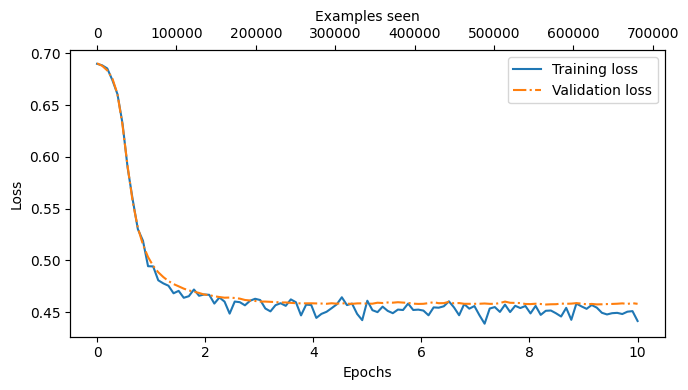

In [51]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(
    epochs_seen=epochs_tensor,
    examples_seen=examples_seen_tensor,
    train_values=train_losses,
    val_values=val_losses,
)

In [52]:
text: str = "This product is not good. I do not recommend it."
text_vec: Tensor = torch.tensor(vect_pipe.transform([text]), dtype=torch.float32)
pred: int = mlp_classifier(text_vec).argmax(-1).detach().numpy()[0]
proba: float = mlp_classifier(text_vec)[:, pred].detach().numpy()[0]
result: str = "Positive" if pred == 1 else "Negative"
print(f"Text: {text} \nPrediction: {result} | (probability: {proba:.4f})")

Text: This product is not good. I do not recommend it. 
Prediction: Positive | (probability: 0.9977)


In [53]:
text: str = "This product is awful."
text_vec: Tensor = torch.tensor(vect_pipe.transform([text]), dtype=torch.float32)
pred: int = mlp_classifier(text_vec).argmax(-1).detach().numpy()[0]
proba: float = mlp_classifier(text_vec)[:, pred].detach().numpy()[0]
result: str = "Positive" if pred == 1 else "Negative"
print(f"Text: {text} \nPrediction: {result} | (probability: {proba:.4f})")

Text: This product is awful. 
Prediction: Negative | (probability: 0.9927)
